# DS-7331 Mini Lab - Logistic Regression and SVMs

### By Ahmad Salama, Titus Karuri, Eman Meraj, Sue Camara

In [7]:
# ---------------------------------------------------------
# Python Library Setup: Check and Install Required Dependencies
# ---------------------------------------------------------
import sys
import subprocess
import importlib.util as imp_util

# List of required libraries\packages for this notebook
required_packages = [
    "pandas",
    "missingno",
    "seaborn",
    "matplotlib",
    "math",
    "scikit-learn",
    "numpy"
]

for package in required_packages:
    # iterate over the required packages and if any is not installed, trigger a pip command
    # to install.
    if imp_util.find_spec(package) is None:
        print(f"Package '{package}' is not installed. Installing now...")
        # run the pip command
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", package],
            stdout=subprocess.DEVNULL
        )
        print(f"Package '{package}' installed successfully.\n")
    else:
        print(f"Package '{package}' is already installed.\n")

# ---------------------------------------------------------
# Import required libraries\packages
# ---------------------------------------------------------
import numpy as np
import pandas as pd
import os as os
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC
import os
os.chdir(r"M:\Titus\SMU Data Science\Machine Learning")

Package 'pandas' is already installed.

Package 'missingno' is already installed.

Package 'seaborn' is already installed.

Package 'matplotlib' is already installed.

Package 'math' is already installed.

Package 'scikit-learn' is not installed. Installing now...
Package 'scikit-learn' installed successfully.

Package 'numpy' is already installed.



In [8]:

DATASET_NAME = "default_of_credit_card_clients.csv"
data_path = os.path.join(os.getcwd(), "data", DATASET_NAME)

# load the dataset
df = pd.read_csv(data_path, header=1)
df.info

<bound method DataFrame.info of           ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  \
0          1      20000    2          2         1   24      2      2     -1   
1          2     120000    2          2         2   26     -1      2      0   
2          3      90000    2          2         2   34      0      0      0   
3          4      50000    2          2         1   37      0      0      0   
4          5      50000    1          2         1   57     -1      0     -1   
...      ...        ...  ...        ...       ...  ...    ...    ...    ...   
29995  29996     220000    1          3         1   39      0      0      0   
29996  29997     150000    1          3         2   43     -1     -1     -1   
29997  29998      30000    1          2         2   37      4      3      2   
29998  29999      80000    1          3         1   41      1     -1      0   
29999  30000      50000    1          2         1   46      0      0      0   

       PAY_4  ...  

### Data Quality Analysis

#### Missing Values Analysis

As you can see below, both the missing values matrix and heatmap show a solid and uninterrupted block across all features. This indicate that there are no explicit missing values in the dataset. This observation is consistent with the dataset documentation, which states that the data does not contain any missing values.


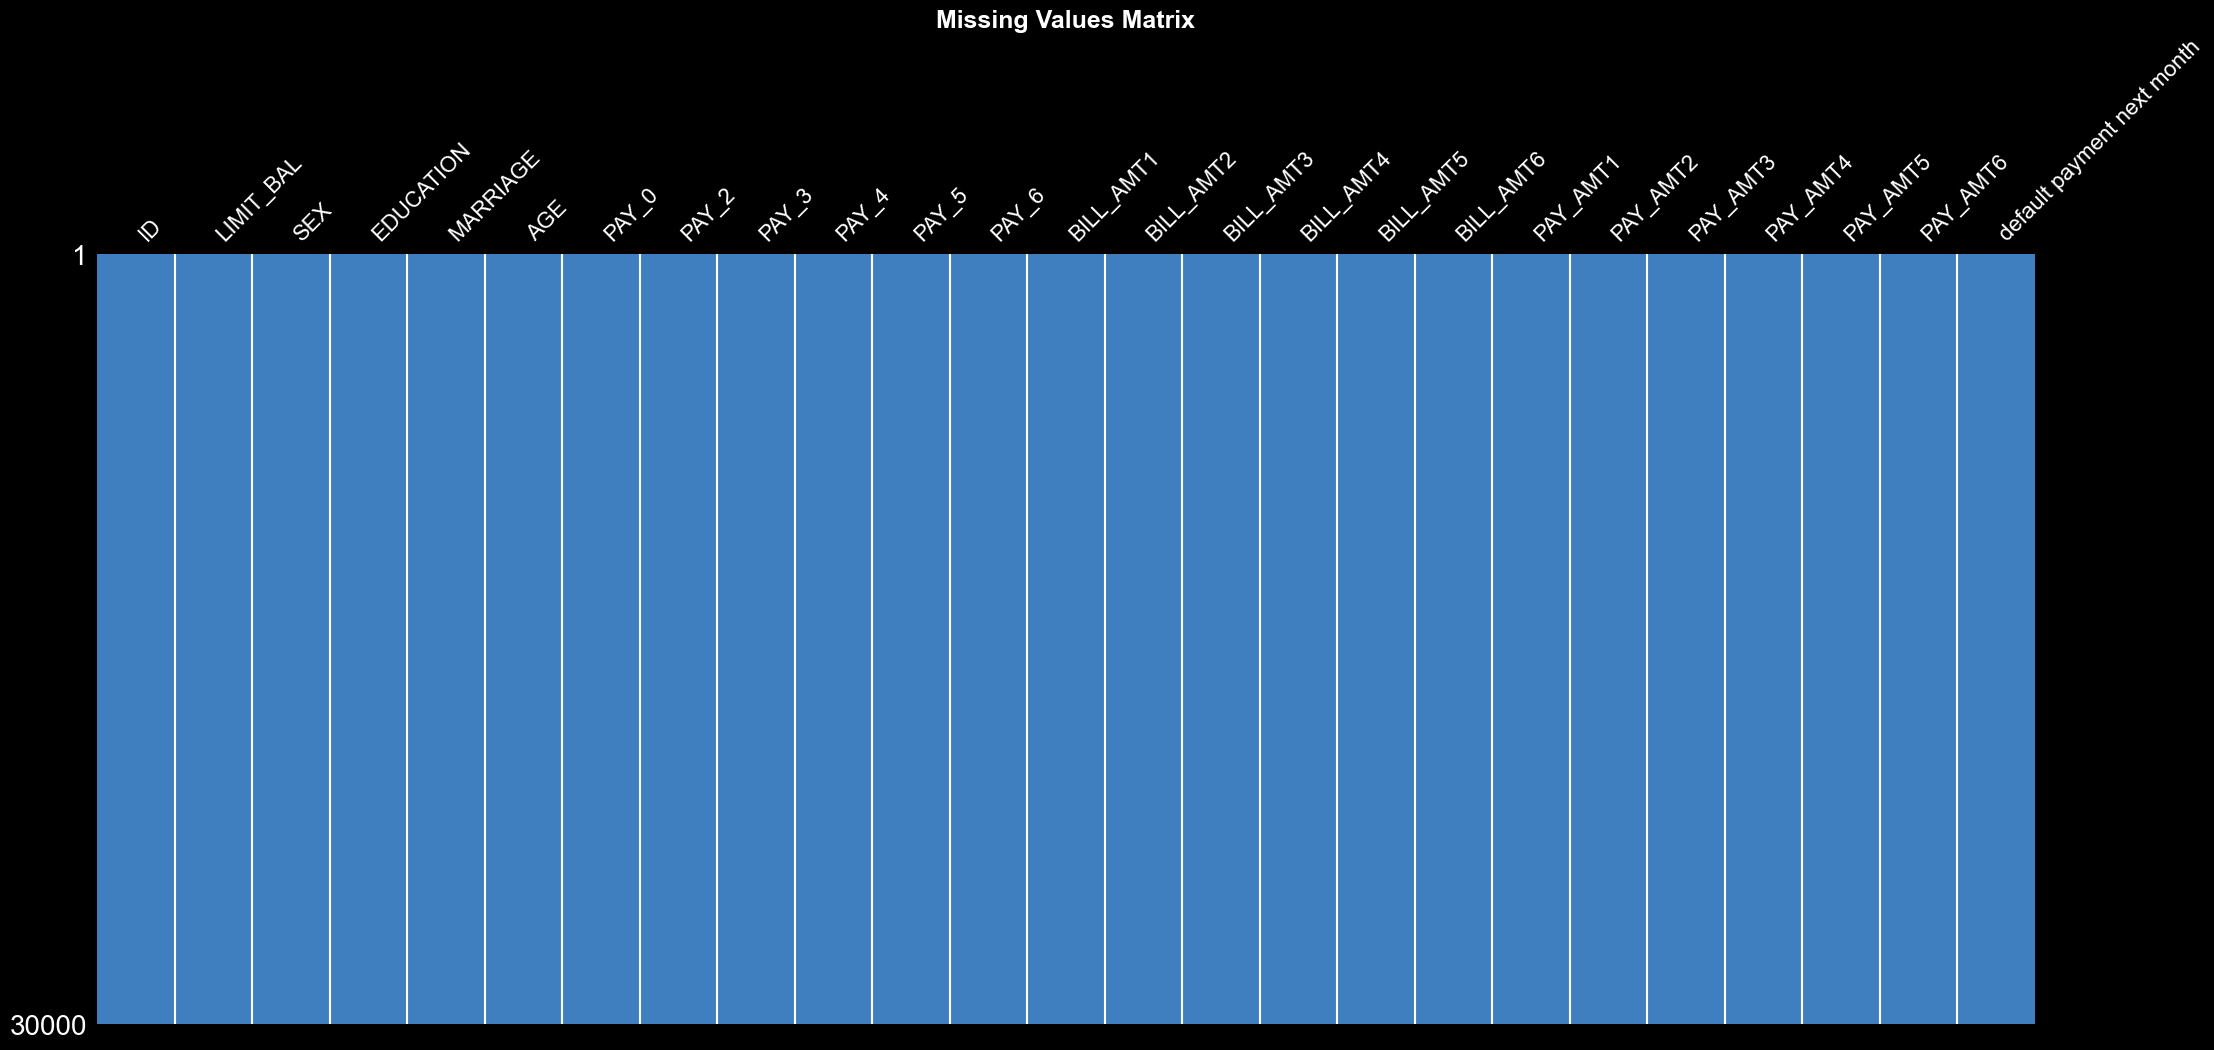

In [9]:
# Visualize dataset completeness using a missingno matrix plot
msno.matrix(
    df,
    color=(0.25, 0.5, 0.75),
    sparkline=False
)
plt.title("Missing Values Matrix", fontsize=18, fontweight="bold")
plt.show()

#### Target Variable Validation

As part of the data quality analysis, we verified that the target variable (`default payment next month`) contains only binary decision values (0 and 1). This validation step ensures that the dataset is appropriate for binary classification models.

In [10]:
# Verify that the target variable contains only binary decision values (0 = no default, 1 = default)
unique = df["default payment next month"].unique()
print(unique)

[1 0]


#### Undocumented Values

While our data doesn't have any missing values, during the previous exploratory analysis, we observed that some categorical features contain values that are undocumented. To better understand the extent and impact of these values, we visualize the distribution of the those variables using heatmaps. As you will see in the heatmaps, the count of the undocumented values are very small and we will be imputing records.

In [11]:
sex = df["EDUCATION"].unique()
print(sex)

[2 1 3 5 4 6 0]


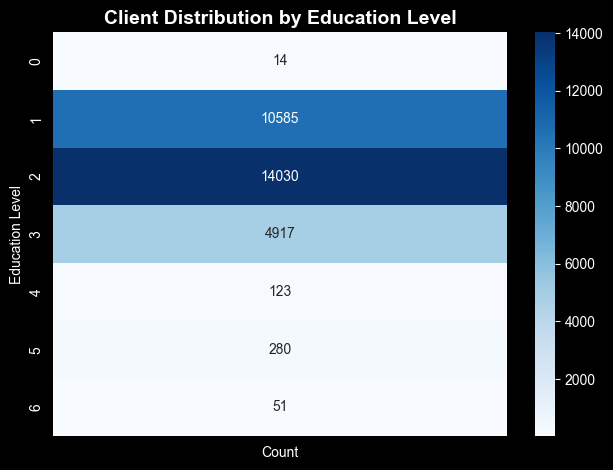

In [12]:
heatmap_data = (
    df["EDUCATION"]
    .value_counts()
    .sort_index()
    .to_frame(name="Count")
)

sns.heatmap(
    heatmap_data,
    cmap="Blues",
    annot=True,
    fmt="d"
)

plt.title("Client Distribution by Education Level", fontsize=14, fontweight="bold")
plt.xlabel("")
plt.ylabel("Education Level")
plt.tight_layout()
plt.show()

In [13]:
# only 1, 2, 3, 4 are in the documentation; remove all others.
df= df[df["EDUCATION"].isin([1,2,3,4])]

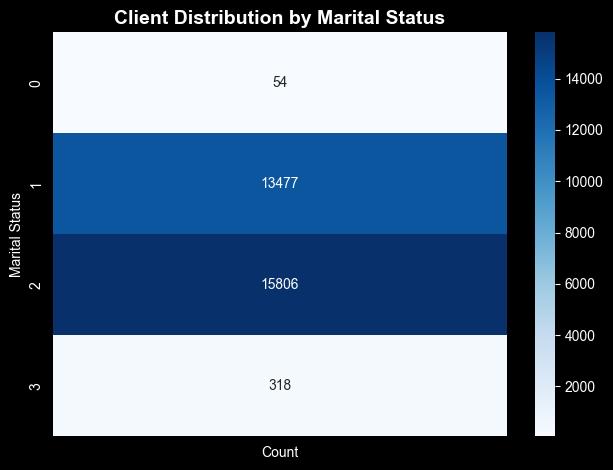

In [14]:
heatmap_marriage = (
    df["MARRIAGE"]
    .value_counts()
    .sort_index()
    .to_frame(name="Count")
)

sns.heatmap(
    heatmap_marriage,
    cmap="Blues",
    annot=True,
    fmt="d"
)

plt.title("Client Distribution by Marital Status", fontsize=14, fontweight="bold")
plt.xlabel("")
plt.ylabel("Marital Status")
plt.tight_layout()
plt.show()

In [15]:
marriage = df["MARRIAGE"].unique()
print(marriage)

[1 2 3 0]


In [16]:
# only 1, 2, 3 are in the documentation; remove all others.
df = df[df["MARRIAGE"].isin([1,2,3])]

In [17]:
# all values are expected.
sex = df["SEX"].unique()
print(sex)

[2 1]


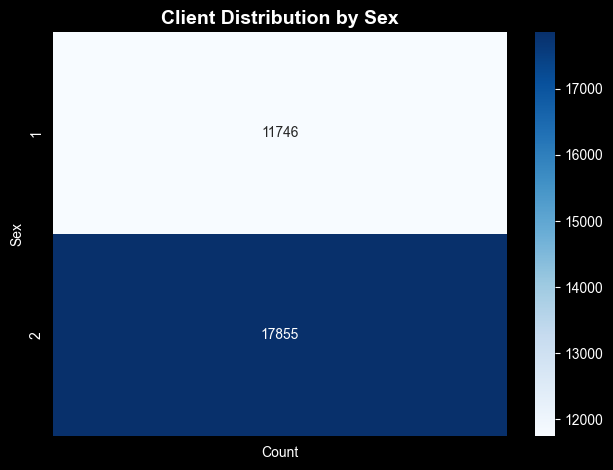

In [18]:
heatmap_sex = (
    df["SEX"]
    .value_counts()
    .sort_index()
    .to_frame(name="Count")
)

sns.heatmap(
    heatmap_sex,
    cmap="Blues",
    annot=True,
    fmt="d"
)

plt.title("Client Distribution by Sex", fontsize=14, fontweight="bold")
plt.xlabel("")
plt.ylabel("Sex")
plt.tight_layout()
plt.show()

# SVM and Logistic Regression Modeling 

In [19]:
# Split into train/test while preserving the class balance in the target
target = "default payment next month"
# Define the target vector
x = df.drop(columns=[target])
y = df[target].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.2, # 20% held out for testing
    random_state=0, # reproducible split
    stratify=y
)

# Overall default rate in the TRAIN set
global_mean = y_train.mean()
print("overall default rate of TRAIN set: ", global_mean)

overall default rate of TRAIN set:  0.2231418918918919


In [20]:

# 1) Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 2) Fit logistic regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# 3) Predict class + probability
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# 4) Evaluate
print("Accuracy:", mt.accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", mt.confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", mt.classification_report(y_test, y_pred))
print("ROC AUC:", mt.roc_auc_score(y_test, y_prob))


Accuracy: 0.813882790069245
Confusion Matrix:
 [[4490  110]
 [ 992  329]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.98      0.89      4600
           1       0.75      0.25      0.37      1321

    accuracy                           0.81      5921
   macro avg       0.78      0.61      0.63      5921
weighted avg       0.80      0.81      0.78      5921

ROC AUC: 0.7348151927064478


Our model does a good job at predicting credit card behavior and shows that about 22% of customers in the data actually default. In addition, this model also improves on this by correctly classifying about 81% of customers, which shows the model is learning meaningful patterns rather than guessing. So, when the model predicts that someone will default, it is usually correct, meaning it prioritizes avoiding false alarms over catching every risky case. Overall, the model is useful as a starting point for credit risk prediction, but it could be improved to identify more high-risk customers. This type of trade-off is common in financial risk models and can be adjusted depending on business needs.

The confusion matrix shows that the model correctly predicts 4,490 non-defaulters and 329 defaulters. However, it also misclassifies 992 defaulters as non-defaulters, which means many high-risk clients are incorrectly predicted as low risk. For the non-default class, the model performs very well, with a recall of 0.98, meaning it correctly identifies almost all low-risk clients. For the default class, however, the recall is only 0.25, which means the model only catches about one quarter of actual defaulters. While the precision for defaulters is relatively high (0.75), indicating that most predicted defaulters truly default, the low recall shows that many defaulters are still being missed.

The ROC-AUC score of approximately 0.73 suggests that the model has moderate ability to distinguish between defaulters and non-defaulters.


In [21]:
# ========================
# Support Vector Machine 
# ========================

# Scale features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Train SVM with linear kernel
svm_model = SVC(kernel="linear", C=1.0, probability=True, random_state=0)
svm_model.fit(X_train_scaled, y_train)

# Predictions
svm_pred = svm_model.predict(X_test_scaled)
svm_prob = svm_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("=== SVM (Linear Kernel) Results ===")
print("Accuracy:", mt.accuracy_score(y_test, svm_pred))
print("Confusion Matrix:\n", mt.confusion_matrix(y_test, svm_pred))
print("\nClassification Report:\n", mt.classification_report(y_test, svm_pred))
print("ROC AUC:", mt.roc_auc_score(y_test, svm_prob))


=== SVM (Linear Kernel) Results ===
Accuracy: 0.813882790069245
Confusion Matrix:
 [[4495  105]
 [ 997  324]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.98      0.89      4600
           1       0.76      0.25      0.37      1321

    accuracy                           0.81      5921
   macro avg       0.79      0.61      0.63      5921
weighted avg       0.80      0.81      0.77      5921

ROC AUC: 0.7069736365730837


In [22]:
# look at the support vectors
print(svm_model.support_vectors_.shape)
print(svm_model.support_.shape)
print(svm_model.n_support_ )

(11646, 24)
(11646,)
[6420 5226]


 There are 11,646 support vectors and each one has 24 features.

[[ 2.00309306e-05  1.88073000e-05  2.35561362e-05  6.18946601e-08
   7.70467118e-06  1.20492618e-05  4.09722464e-01  2.18409483e-01
   2.86741188e-05  2.16771572e-05  6.17748738e-05 -1.18105692e-05
  -8.91241214e-06  4.51544135e-05 -8.90127679e-06 -6.71920991e-06
  -1.04492410e-05  2.42286565e-05 -2.84924573e-04 -1.16040869e-05
   5.58976049e-06 -1.79737743e-05 -9.65838213e-06 -1.58864172e-05]]


<AxesSubplot:>

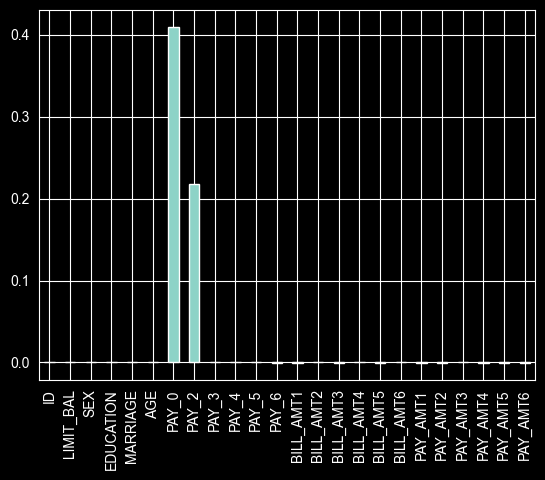

In [23]:
# if using linear kernel, these make sense to look at (not otherwise, why?)
print(svm_model.coef_)
weights = pd.Series(svm_model.coef_[0],index=x.columns)
weights.plot(kind='bar')

 The coefficient plot shows that the linear SVM’s decision boundary is driven primarily by repayment status variables (especially PAY_0 and PAY_2), while other features have near-zero coefficients, suggesting they add little additional linear separation beyond those dominant signals.

In [24]:
# we want to predict the X and y data as follows:
if target in df:
    y = df[target].values # get the labels we want
    X = df.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [25]:
iter_num=0
log_reg2 = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    log_reg2.fit(X_train,y_train)  # train object
    y_hat = log_reg2.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1

====Iteration 0  ====
accuracy 0.768957946292856
confusion matrix
 [[4553    0]
 [1368    0]]
====Iteration 1  ====
accuracy 0.7817936159432528
confusion matrix
 [[4629    0]
 [1292    0]]
====Iteration 2  ====
accuracy 0.77402465799696
confusion matrix
 [[4583    0]
 [1338    0]]


Using cross-validation, Logistic Regression produced ~0.77 accuracy

In [26]:
# make a dataframe of the training data
df_tested_on = df.iloc[y_train].copy() # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_model.support_,:].copy()

df_support[target] = y[svm_model.support_] # add back in the 'Survived' Column to the pandas dataframe
df[target] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11646 entries, 0 to 0
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          11646 non-null  int64
 1   LIMIT_BAL                   11646 non-null  int64
 2   SEX                         11646 non-null  int64
 3   EDUCATION                   11646 non-null  int64
 4   MARRIAGE                    11646 non-null  int64
 5   AGE                         11646 non-null  int64
 6   PAY_0                       11646 non-null  int64
 7   PAY_2                       11646 non-null  int64
 8   PAY_3                       11646 non-null  int64
 9   PAY_4                       11646 non-null  int64
 10  PAY_5                       11646 non-null  int64
 11  PAY_6                       11646 non-null  int64
 12  BILL_AMT1                   11646 non-null  int64
 13  BILL_AMT2                   11646 non-null  int64
 14  BILL_AMT3      

# Advantages of each model for each classification task

In [27]:
# ============================
# SVM Parameter Adjustment 
# ============================

C_values = [0.01, 0.1, 1]

best_C = None
best_auc = -1

print("=== Linear SVM Tuning (C values) ===")
for C in C_values:
    svm_tuned = SVC(kernel="linear", C=C, probability=True, random_state=0)
    svm_tuned.fit(X_train_scaled, y_train)

    pred = svm_tuned.predict(X_test_scaled)
    prob = svm_tuned.predict_proba(X_test_scaled)[:, 1]

    svm_acc  = mt.accuracy_score(y_test, pred)
    svm_auc = mt.roc_auc_score(y_test, prob)

    print(f"C={C:<6}  Accuracy={svm_acc:.3f}  ROC_AUC={svm_auc:.3f}")

    if svm_auc > best_auc:
        best_auc = svm_auc
        best_C = C

print(f"\nBest C based on ROC AUC: {best_C} (ROC AUC = {best_auc:.3f})")


=== Linear SVM Tuning (C values) ===
C=0.01    Accuracy=0.774  ROC_AUC=0.509
C=0.1     Accuracy=0.774  ROC_AUC=0.498
C=1       Accuracy=0.774  ROC_AUC=0.497

Best C based on ROC AUC: 0.01 (ROC AUC = 0.509)


 ## Comparison of Logistic Regression and SVM Models

The SVM provides a modest improvement in accuracy after adjusting the parameters, but both models have ROC AUC values only slightly above 0.50, indicating they have very limited ability to distinguish between the two classes beyond chance. This suggests that while the models may perform well on the majority class, their overall discriminative power is weak, and further improvements likely require addressing class imbalance



In [28]:

results = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM (Linear)"],
    "Accuracy": [mt.accuracy_score(y_test, y_pred), svm_acc],
    "ROC AUC": [mt.roc_auc_score(y_test, y_prob), best_auc]
})

results


,Model,Accuracy,ROC AUC
0,Logistic Regression,0.733660,0.508463
1,SVM (Linear),0.774025,0.508743


# Logistic Regression Coefficient Interpretation

In [29]:
coef_df = pd.DataFrame({
    "Feature": x.columns,
    "Coefficient": log_reg.coef_[0]
})

coef_df.sort_values(by="Coefficient", ascending=False)

,Feature,Coefficient
6,PAY_0,0.633641
16,BILL_AMT5,0.142934
13,BILL_AMT2,0.121124
7,PAY_2,0.089995
8,PAY_3,0.070874
10,PAY_5,0.069997
14,BILL_AMT3,0.060224
5,AGE,0.058351
15,BILL_AMT4,0.046736
9,PAY_4,0.031142


##### The most influential feature in the model is PAY_0, with a coefficient of 0.63. This indicates that more recent repayment delays strongly increase the probability of default. This result makes intuitive sense, as customers who are currently behind on payments are much more likely to default than those who are up to date.

##### BILL_AMT1 has a relatively large negative coefficient (−0.38), suggesting that higher recent bill amounts are associated with a lower probability of default when controlling for other variables. Similarly, PAY_AMT1 and PAY_AMT2 both have negative coefficients, indicating that customers who make larger payments tend to have lower default risk.

##### The LIMIT_BAL has a small negative coefficient (−0.09), which implies that customers with higher credit limits are slightly less likely to default.

##### The variable PAY_2 also appears among the top features, though with a much smaller positive coefficient (0.09) compared to PAY_0. This suggests that repayment delays further in the past still matter, but are less predictive than more recent behavior.

Overall, the results show that repayment behavior, especially recent payment status, is the strongest driver of default risk in this dataset. Payment amounts and billing information provide additional insight, while demographic variables play a less role in predicting default. This is interesting and need further examine and probably feature engineering could enable us to extract more prediction power from the demographic.

In [30]:
weights = log_reg.coef_.T # take transpose to make a column vector
variable_names = df.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

ID has weight of -0.023539185032844745
LIMIT_BAL has weight of -0.09119969562652684
SEX has weight of -0.04602272193247824
EDUCATION has weight of -0.05123121995705514
MARRIAGE has weight of -0.08712594651205095
AGE has weight of 0.05835105442645226
PAY_0 has weight of 0.6336412726433369
PAY_2 has weight of 0.08999549919860728
PAY_3 has weight of 0.07087447190495214
PAY_4 has weight of 0.031141673027839885
PAY_5 has weight of 0.06999669547668928
PAY_6 has weight of 0.00604110288659677
BILL_AMT1 has weight of -0.3824378511079402
BILL_AMT2 has weight of 0.12112439637255969
BILL_AMT3 has weight of 0.060224418957803665
BILL_AMT4 has weight of 0.04673606646945056
BILL_AMT5 has weight of 0.14293359543362766
BILL_AMT6 has weight of -0.09333553029529011
PAY_AMT1 has weight of -0.22262009828287996
PAY_AMT2 has weight of -0.22087333272458032
PAY_AMT3 has weight of -0.07973584036341885
PAY_AMT4 has weight of -0.05089966568080651
PAY_AMT5 has weight of -0.0425635420445147
PAY_AMT6 has weight of -0

Features like PAY_0 / PAY_2 (repayment status) are directly tied to delinquency history, so they tend to be strongly predictive. If a variable is closely linked to the outcome, the model gives it a larger coefficient because it consistently improves separation. while negative coefficients (notably BILL_AMT1 and payment amounts PAY_AMT1/2) are most important for predicting the non-default class; overall, behavioral credit variables dominate demographic features

In [31]:


# Define target and predictors
target = "default payment next month"
y = df[target].astype(int)
X = df.drop(columns=[target])

# Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train logistic regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Create feature importance table
coef_table = pd.DataFrame({
    "Feature": X_train.columns,
    "Weight": log_reg.coef_[0],
    "Importance": np.abs(log_reg.coef_[0])
}).sort_values("Importance", ascending=False)

coef_table.head(10)


,Feature,Weight,Importance
6,PAY_0,0.633641,0.633641
12,BILL_AMT1,-0.382438,0.382438
18,PAY_AMT1,-0.222620,0.222620
19,PAY_AMT2,-0.220873,0.220873
16,BILL_AMT5,0.142934,0.142934
13,BILL_AMT2,0.121124,0.121124
17,BILL_AMT6,-0.093336,0.093336
1,LIMIT_BAL,-0.091200,0.091200
7,PAY_2,0.089995,0.089995
4,MARRIAGE,-0.087126,0.087126


PAY_0 is the dominant positive driver of credit card defaults, while BILL_AMT1 and the payment amount variables (PAY_AMT1, PAY_AMT2) have large negative coefficients, meaning higher payment behavior is associated with the no-default class.

# Chosen support vectors

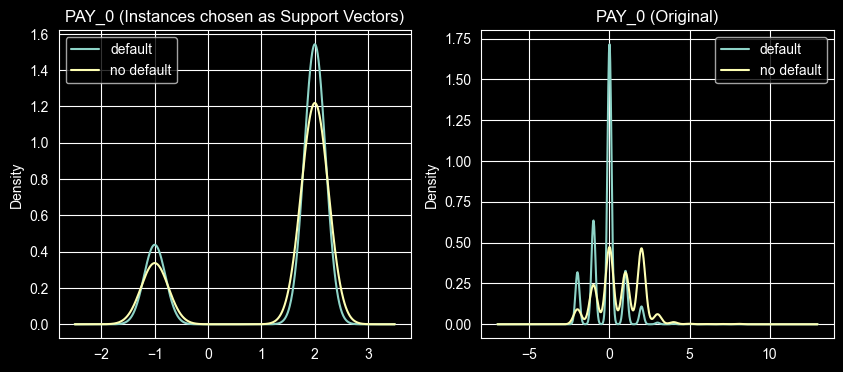

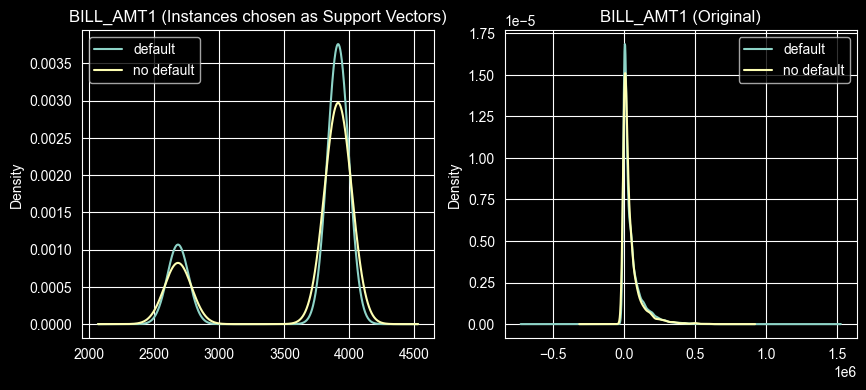

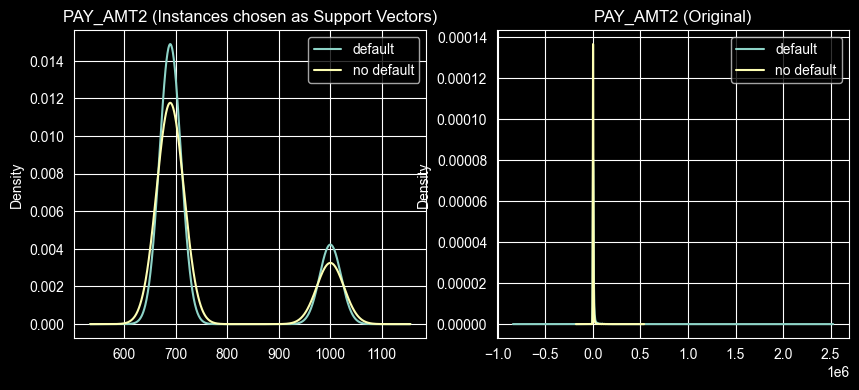

In [32]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby([target])
df_grouped = df.groupby([target])

# plot KDE of Different variables
vars_to_plot = ['PAY_0','BILL_AMT1', 'PAY_AMT2']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['default', 'no default'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['default', 'no default'])
    plt.title(v+' (Original)')

 The support vectors say that the SVM decision making is happening in the tails or non zero regions, while the raw data is dominated by the zeros and heavy skew.non-zero